<a href="https://colab.research.google.com/github/ElisabethShah/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

## Challenge

Using Python, write code that quantifies the following data:

Grow Mart, Plant Depot, and Trees’R’Us are gardening stores in a city. Grow Mart and Plant Depot were both founded in 1973, and Trees’R’Us was founded in 1985. Grow Mart has annual revenue of ```$```265k and expenses of ```$```183k, Plant Depot has ```$```302k revenue and ```$```240k expenses, and Trees’R’Us has ```$```123k revenue and ```$```130k expenses.

In addition to describing the above, add a feature is_profitable. What sort of feature should this be, and how should it be determined? 

In [1]:
 # Set up a dataframe to store the gardening store details.

import pandas as pd

data = {'store_name': ['Grow Mart', 'Plant Depot', 'Trees’R’Us'],
        'year_established': [1973, 1973, 1985],
        'annual_revenue': [265000, 302000, 123000],
        'annual_expenses': [183000, 240000, 130000]}

stores = pd.DataFrame(data)
stores

,store_name,year_established,annual_revenue,annual_expenses
0,Grow Mart,1973,265000,183000
1,Plant Depot,1973,302000,240000
2,Trees’R’Us,1985,123000,130000


In [2]:
# Add a binary (boolean) feature is_profitable, indicating whether revenue 
# exceeds expenses for each store.

stores['is_profitable'] = stores['annual_revenue'] > stores['annual_expenses']
stores

,store_name,year_established,annual_revenue,annual_expenses,is_profitable
0,Grow Mart,1973,265000,183000,True
1,Plant Depot,1973,302000,240000,True
2,Trees’R’Us,1985,123000,130000,False


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [3]:
# Reference: https://github.com/iamaziz/PyDataset

! pip install pydataset

    100% |████████████████████████████████| 15.9MB 2.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/fe/3f/dc/5d02ccc767317191b12d042dd920fcf3432fab74bc7978598b
Successfully built pydataset


In [4]:
from pydataset import data

initiated datasets repo at: /root/.pydataset/


In [5]:
# Import and display the data for Anscombe's quartet.

anscombe = data('anscombe')
anscombe

,x1,x2,x3,x4,y1,y2,y3,y4
1,10,10,10,8,8.04,9.14,7.46,6.58
2,8,8,8,8,6.95,8.14,6.77,5.76
3,13,13,13,8,7.58,8.74,12.74,7.71
4,9,9,9,8,8.81,8.77,7.11,8.84
5,11,11,11,8,8.33,9.26,7.81,8.47
6,14,14,14,8,9.96,8.10,8.84,7.04
7,6,6,6,8,7.24,6.13,6.08,5.25
8,4,4,4,19,4.26,3.10,5.39,12.50
9,12,12,12,8,10.84,9.13,8.15,5.56
10,7,7,7,8,4.82,7.26,6.42,7.91


In [0]:
import matplotlib.pyplot as plt

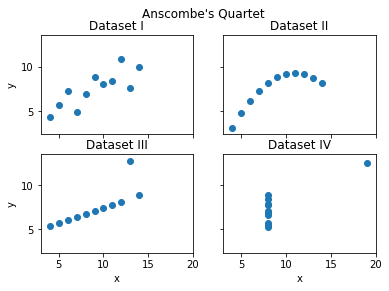

In [28]:
# Display scatterplots for the four datasets of the quartet.

f, axarr = plt.subplots(2, 2, sharex='all', sharey='all')
f.suptitle('Anscombe\'s Quartet')

# Assign data and titles to subplots.
axarr[0, 0].scatter(anscombe['x1'], anscombe['y1'])
axarr[0, 0].set_title('Dataset I')
axarr[0, 1].scatter(anscombe['x2'], anscombe['y2'])
axarr[0, 1].set_title('Dataset II')
axarr[1, 0].scatter(anscombe['x3'], anscombe['y3'])
axarr[1, 0].set_title('Dataset III')
axarr[1, 1].scatter(anscombe['x4'], anscombe['y4'])
axarr[1, 1].set_title('Dataset IV')

# Set axis labels.
for ax in axarr.flat:
    ax.set(xlabel='x', ylabel='y')

# Hide unneeded labels.
for ax in axarr.flat:
    ax.label_outer()

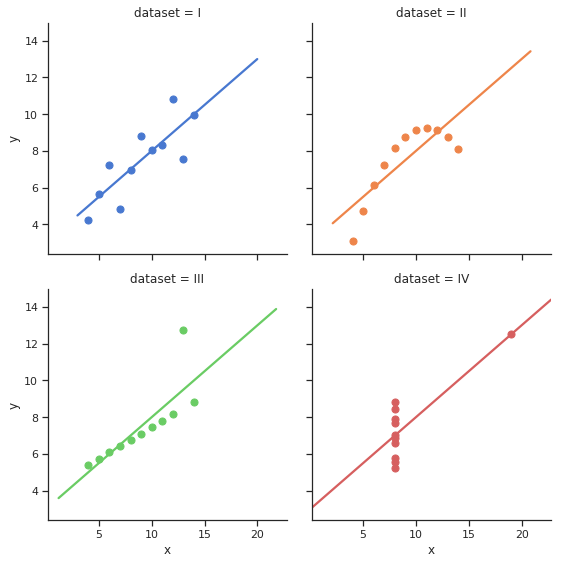

In [31]:
# Seaborn version (with linear regression)
# Source: https://seaborn.pydata.org/examples/anscombes_quartet.html

import seaborn as sns
sns.set(style="ticks")

# Load the example dataset for Anscombe's quartet
df = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1});

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.